## インポート

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

np.random.seed(1234)

## データの読み込み

In [16]:
df = pd.read_csv('chap05/input/data-attendance-3.txt')
print(df.shape)
df.head()

(2396, 5)


,PersonID,A,Score,Weather,Y
0,1,0,69,B,1
1,1,0,69,A,1
2,1,0,69,C,1
3,1,0,69,A,1
4,1,0,69,B,1


In [17]:
#df = df.join(pd.get_dummies(df.Weather, prefix='Weather', drop_first=True))
df.Weather = df.Weather.replace(to_replace=['A', 'B', 'C'], value=[1,2,3])
df.head()

,PersonID,A,Score,Weather,Y
0,1,0,69,2,1
1,1,0,69,1,1
2,1,0,69,3,1
3,1,0,69,1,1
4,1,0,69,2,1


## モデル式の記述

$q[i] = \beta_1 + \beta_2 A[i] + \beta_3 Score[i] + \beta_4[Weather[i]] $

$Y[i]$ ~ $ Bernoulli( q[i] )$

$i = 1,...,I$

## Stanでの実装

In [19]:
model_code="""
data {
  int I;
  int<lower=0, upper=1> A[I];
  real<lower=0, upper=1> Score[I];
  int<lower=1, upper=3> WID[I];
  int<lower=0, upper=1> Y[I];
}
parameters {
  real b1;
  real b2;
  real b3;
  real b4;
  real b5;
}
transformed parameters {
  real bw[3];
  bw[1] = 0;
  bw[2] = b4;
  bw[3] = b5;
}
model {
  for (i in 1:I)
    Y[i] ~ bernoulli_logit(b1 + b2*A[i] + b3*Score[i] + bw[WID[i]]);
}
"""

from pystan import StanModel
data = dict(I=df.shape[0], A=df.A, Score=df.Score/200, WID=df.Weather, Y=df.Y)
sm = StanModel(model_code=model_code)

fit = sm.sampling(data=data, n_jobs=1, seed=123)
#fit

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3585b56f6ddba5b7263f1507a1ec2595 NOW.


## traceplot

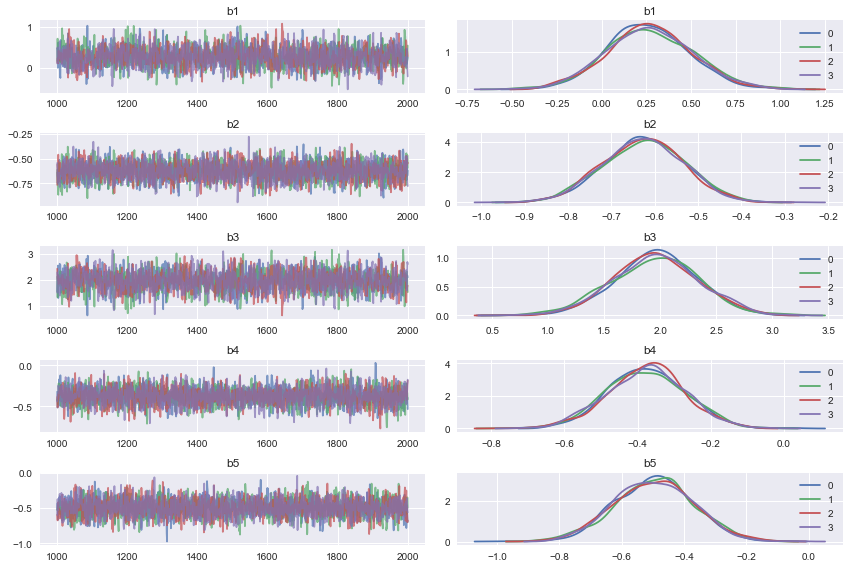

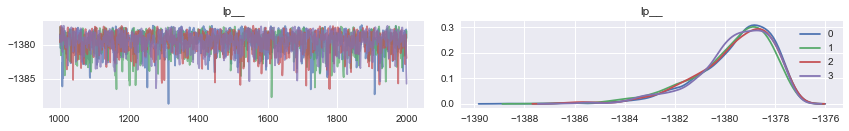

In [20]:
import math

palette = sns.color_palette()
ms = fit.extract(permuted=False, inc_warmup=True)
iter_from = fit.sim['warmup']
iter_range = np.arange(iter_from, ms.shape[0])
paraname = fit.sim['fnames_oi'][:5]
paraname.append(fit.sim['fnames_oi'][-1]) # 'lp__' もtrace plot に追加
paraname_key = [fit.sim['fnames_oi'].index(paran) for paran in paraname]

gpp = 5 # 画像１枚あたりの縦方向のグラフ数 gpp:graph per page
num_pages = math.ceil(len(paraname)/gpp)  # parameter 数をgppで割った数より大きい最少の整数=画像枚数

for pg in range(num_pages):  # 1ページにgppx2のグラフをプロットする
    plt.figure(figsize=(12,8))
    for pos in range(gpp):
        pi = pg*gpp + pos
        if pi >= len(paraname): break
        # trace plot
        plt.subplot(gpp, 2, 2*pos+1)
        plt.tight_layout()
        [plt.plot(iter_range + 1, ms[iter_range,ci,paraname_key[pi]], color=palette[ci], label=ci, alpha=.7) for ci in range(ms.shape[1])]
        
        plt.title(paraname[pi])
        # posterior distribution 
        plt.subplot(gpp, 2, 2*(pos+1))
        plt.tight_layout()
        [sns.kdeplot(ms[iter_range,ci,paraname_key[pi]], color=palette[ci], label=ci) for ci in range(ms.shape[1])]
        plt.title(paraname[pi])
        plt.legend()

In [22]:
fit

Inference for Stan model: anon_model_3585b56f6ddba5b7263f1507a1ec2595.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b1      0.27  5.1e-3   0.23  -0.19   0.11   0.26   0.42   0.74   2087    1.0
b2     -0.63  1.6e-3   0.09   -0.8  -0.69  -0.62  -0.56  -0.45   3262    1.0
b3      1.96  8.1e-3   0.37   1.21   1.71   1.96   2.21   2.68   2162    1.0
b4     -0.38  1.8e-3   0.11  -0.58  -0.45  -0.37  -0.31  -0.17   3255    1.0
b5      -0.5  2.1e-3   0.12  -0.74  -0.58  -0.49  -0.41  -0.25   3513    1.0
bw[0]    0.0     0.0    0.0    0.0    0.0    0.0    0.0    0.0   4000    nan
bw[1]  -0.38  1.8e-3   0.11  -0.58  -0.45  -0.37  -0.31  -0.17   3255    1.0
bw[2]   -0.5  2.1e-3   0.12  -0.74  -0.58  -0.49  -0.41  -0.25   3513    1.0
lp__   -1379    0.04   1.56  -1383  -1380  -1379  -1378  -1377   1683    1.0

Samples were drawn using NUTS at Thu May

In [25]:
print(np.exp(-0.38))  # 曇りの場合のオッズ比
print(np.exp(-0.5))  # 雨の場合のオッズ比

0.683861409212
0.606530659713
